# Rappel  
(dans le cas d'une utilisation sur votre poste personnel)
Avant de commencer, assurez-vous d’avoir Scikit-learn installé (de préférence dans un environnement virtuel en utilisant conda) :
pip install scikit-learn

sinon, à l'insa : 

``` $ source /opt/venv/stpi-m8/bin/activate``` 

``` $ python -m ipykernel install --user --name M8``` 

``` $ jupyter notebook``` 

Nous utilisons un notebook Python. Cet outil est intéressant pour prototyper rapidement du code mais peut s'avérer difficile (car les cellules peuvent être lancées dans un ordre arbitraire et provoquer des effets de bord)

## Rappels théoriques

### Qu'est-ce que le clustering ?

Le *clustering* est une méthode d’apprentissage non supervisé visant à regrouper des données similaires entre elles. Contrairement à la classification, on ne dispose pas de labels pour les données. L’algorithme identifie des structures ou regroupements (au sens d'un certain critère) dans les données.

---

### Algorithme K-Means (ou K-moyennes)

L’algorithme **K-Means** (ou K-moyennes) est l’un des algorithmes de clustering les plus populaires. Il cherche à diviser un ensemble de données en **k groupes** (clusters) en minimisant la distance intra-cluster. Chaque cluster aura pour représentant sa moyenne (ie. son centroïde).

#### Objectif : minimiser l’inertie intra-cluster

$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$

où :
- $ C_i $ : le i-ème cluster,
- $ \mu_i $: le centroïde (moyenne) du cluster $ C_i $,
- $ x $ : un point appartenant à $ C_i $.

---

### Fonctionnement de l’algorithme

1. Initialiser aléatoirement \( k \) centroïdes.
2. Assigner chaque point au centroïde le plus proche (création des clusters).
3. Recalculer les centroïdes comme la moyenne des points de chaque cluster.
4. Répéter les étapes 2 et 3 jusqu’à convergence (plus de changement d’assignation ou centre stable).

---

### Hypothèses et limitations de K-Means

- Suppose que les clusters sont **sphériques** et de taille comparable.
- Sensible à **l'initialisation** (valeurs initiales des centroïdes).
- Nécessite de connaître **a priori** le nombre de clusters \( k \).
- Mal adapté à des clusters de formes complexes, imbriquées ou de tailles différentes.

---

### Point méthodologique 

- La comparaison de modèles de clustering est un problème mal posé...
- On ne dispose pas de labels (pas de vérités terrain) et si on en avait, on aurait tout intérêt à utiliser un algorithme supervisé
- Il existe cependant  des métriques pour le clustering


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score


# clustering de données synthétiques 

Dans cette partie, nous allons évaluer l'influence du nombre de clusters et de l'initialisation sur un résultat de k-moyennes. 

## génération de données synthétiques

- générer (avec scikit-learn) un jeu de données de $300$ points (en 2D) répartis en $4$ clusters et avec écart-type de $0.60$ (on fixera le générateur pseudo-aléatoire à l'état $0$).


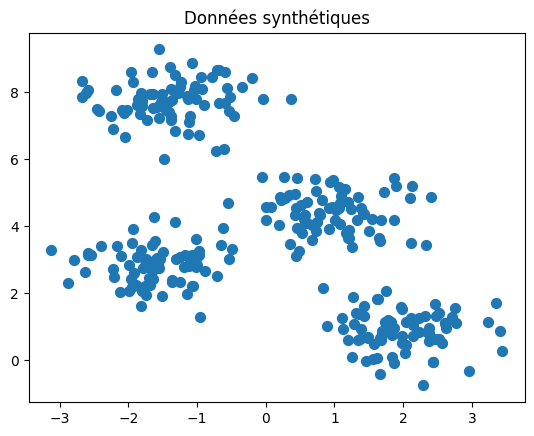

In [67]:
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Données synthétiques")
plt.show()


## Influence du nombre de clusters

- Pour $k \in [ 2, 6]$ appliquer l'algorithme de k-means
- Dans une figure différente, pour chaque valeur de $k$, afficher le nuage de point (en colorant chaque point suivant son cluster prédit) et représenter la moyenne de chaque cluster.


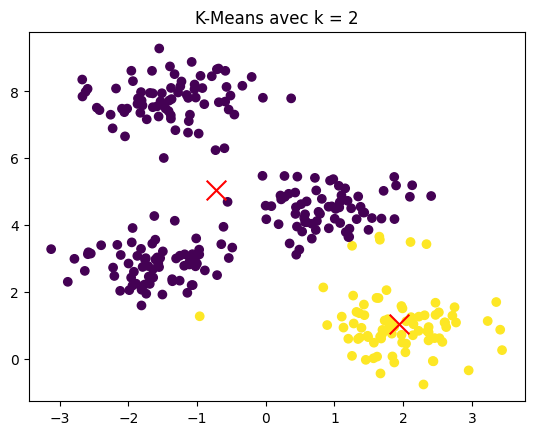

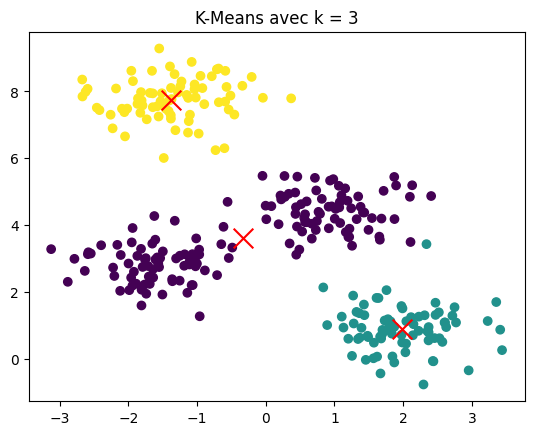

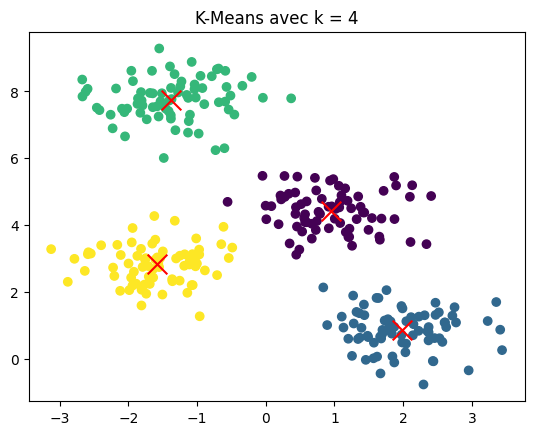

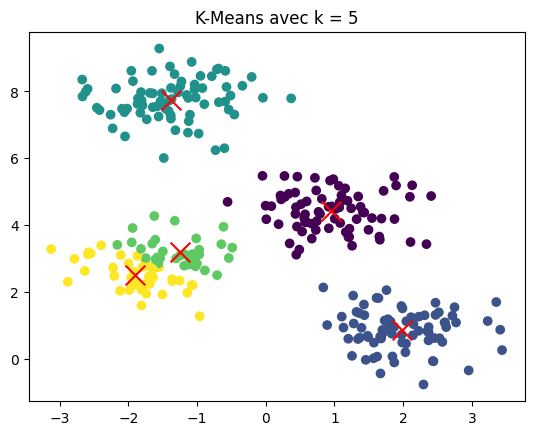

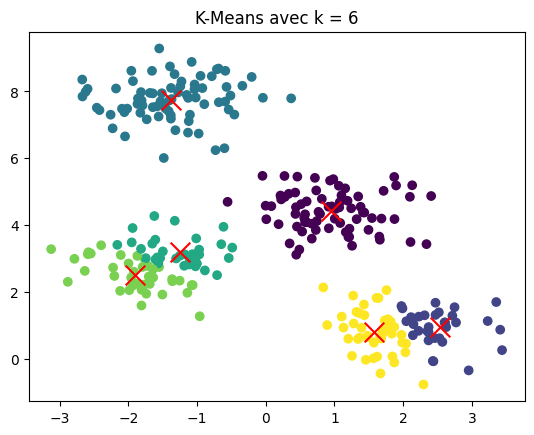

In [68]:
ks = [2, 3, 4, 5, 6]

for k in ks:
    
    kmeans = KMeans(n_clusters=k, random_state = 0)
    y_means = kmeans.fit_predict(X)
    
    plt.scatter(X[:,0], X[:,1], c = y_means)
    
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:,0], centers[:,1], c = 'red', marker = 'x', s = 200, label='centres')
    plt.title(f"K-Means avec k = {k}")
    plt.show()
    


## Influence du nombre de l'initialisation

- Pour $k = 9 $ appliquer l'algorithme de k-means avec ``random_state`` différents (au hasard $40$ et $42$).
- Dans deux figures différentes, afficher le nuage de point (en colorant chaque point suivant son cluster prédit) et représenter la moyenne de chaque cluster. Que peut-on en dire ?

Bonus : 
- on pourra essayer de comparer quantitativement le degré de consensus entre les cluster.
  Pour cela, on regardera la métrique "Adjusted rand index" (ARI) par exemple.
- on pourra tester plusieurs valeurs $k$ pour voir si certains cas semblent plus stables que d'autres.



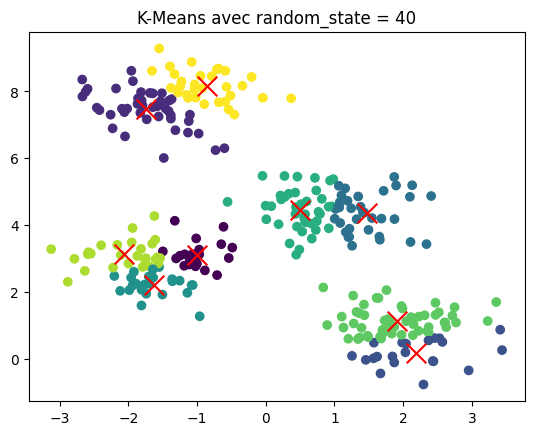

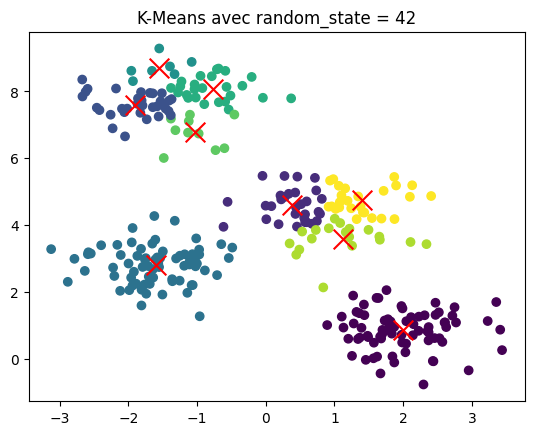

Adjusted round index = 0.5942459666907111


In [69]:
k=9

kmeans1 = KMeans(n_clusters=9, random_state = 40)
y_means1 = kmeans1.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c = y_means1)

centers1 = kmeans1.cluster_centers_
plt.scatter(centers1[:,0], centers1[:,1], c = 'red', marker = 'x', s = 200, label='centres')
plt.title(f"K-Means avec random_state = 40")
plt.show()

kmeans2 = KMeans(n_clusters=9, random_state = 42)
y_means2 = kmeans2.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c = y_means2)

centers2 = kmeans2.cluster_centers_
plt.scatter(centers2[:,0], centers2[:,1], c = 'red', marker = 'x', s = 200, label='centres')
plt.title(f"K-Means avec random_state = 42")
plt.show()


ari = adjusted_rand_score(y_means1,y_means2)
print(f"Adjusted round index = {ari}")


#inertie plus faible pour le premier modele, les clusters sont plus gros

## Choix du nombre de clusters

Le choix de \( k \) est crucial. Plusieurs méthodes peuvent être utilisées :
- **Méthode du coude (elbow method)** : observer l’inertie en fonction de \( k \).
- **Score de silhouette** : mesure de cohésion et de séparation entre clusters.
- **Critères externes** si les étiquettes sont disponibles (ex. Adjusted Rand Index, ARI).


Dans un premier temps, on va tester la méthode du coude : 
- entrainer un k-means pour $k\in [2, 10]$ et enregister l'inertie du modèle entrainé
- afficher la courbe de l'inertie en fonction de $k$.
- le coude confirme-t-il l'intuition graphique précédente ? et est-il cohérent avec la génération de données ?

Bonus :
- On peut regarder une première métrique appelée Silhouette pour chaque modèle.
- afficher la valeur de la silhouette en fonction de $k$
- est-ce cohérent avec les résultats précédents ?


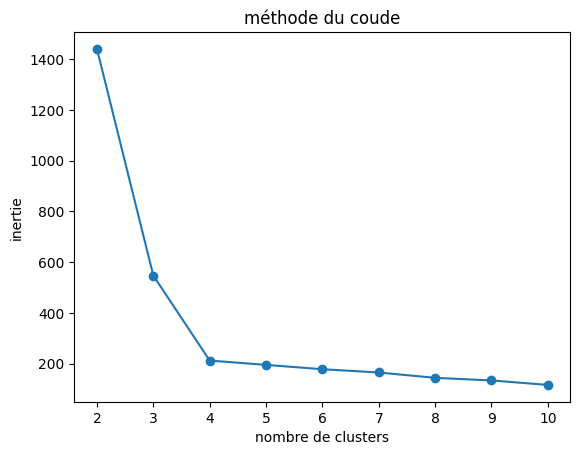

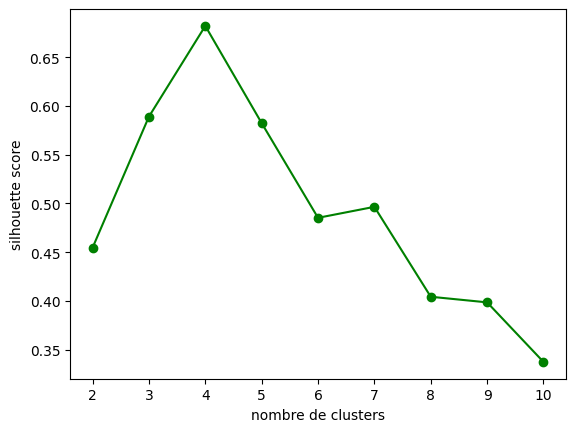

In [74]:
inerties = []
score = []

for k in range(2,11):
    
    kmeans = KMeans(n_clusters=k, random_state = 0)
    y_means = kmeans.fit_predict(X)
    inerties.append(kmeans.inertia_)
    score.append(silhouette_score(X, y_means))
    
plt.plot(range(2,11), inerties, marker='o')
plt.title('méthode du coude')
plt.xlabel('nombre de clusters')
plt.ylabel('inertie')
plt.show()


plt.plot(range(2,11), score, marker='o', c = 'green')
plt.xlabel('nombre de clusters')
plt.ylabel('silhouette score')
plt.show()
    


# clustering de données réelles 

Dans cette partie, nous allons appliquer ce que nous avons appris sur de vraies données

## dataset Digit

- charger les données ``digits`` (avec scikit-learn), ce jeu de données (conçu à la base pour de la classification) contient $1797$ observations pour $64$ variables.

In [82]:
digits = load_digits()

X, y = digits.data, digits.target

print(digits.data.shape)

(1797, 64)


## Réduction de dimensions

Pour rester dans des exemples que l'on peut visualiser, nous allons 
- appliquer une ACP pour réduire ce jeu de  données à deux dimensions
- afficher le nuage de points projeté sur les deux premiers axes principaux (en faisant apparaître la classe de chaque point par une couleur)

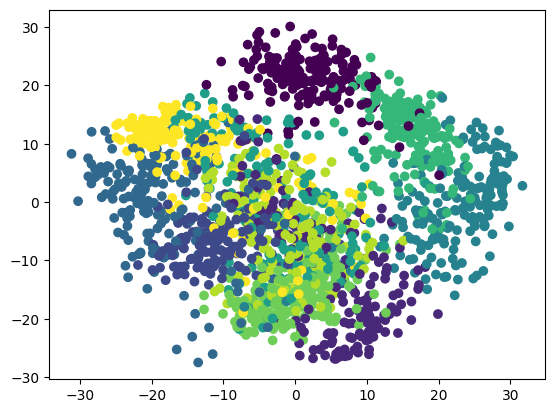

In [88]:
pca = PCA(n_components=2)
X_acp = pca.fit_transform(X)

plt.scatter(X_acp[:,0],X_acp[:,1], c = y)

## k-means

- appliquer un algorithmes k-means avec $k=10$ (sur les données réduites en 2D)
- afficher le nuage de points projeté sur les deux premiers axes principaux (en faisant apparaître l'appartenance à un cluster de chaque point par une couleur)

Bonus :
- l'initialisation et le nombre de cluster ont-ils un impact sur ce clustering ?

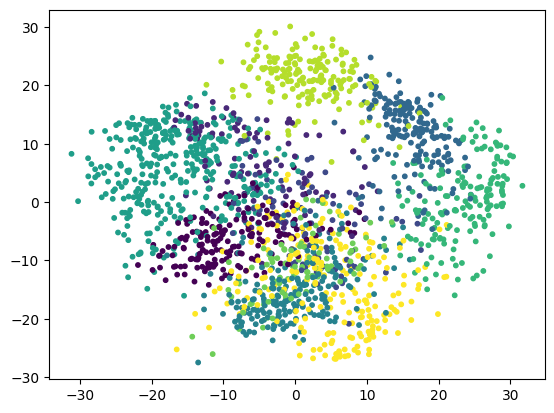

In [98]:
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(X)
plt.scatter(X_acp[:, 0], X_acp[:, 1], c=clusters, s=10)
plt.show()

## Visualisation des représentants de chaque cluster

Note : Chaque observation est une image $8 \times 8$ vectorisée pour obtenir un vecteur de taille $64$. A l'aide de la fonction ``reshape``nous pourrions affichier l'image de chaque observation (avec la fonction ``imshow``).


- La moyenne de chaque cluster est un vecteur de taille $64$. En appliquant la procédure précédente, afficher l'image que représente chaque centroïde.
- Reconnait-on des chiffres ? ces représentants des clsuters semblent-ils avoir du sens ?

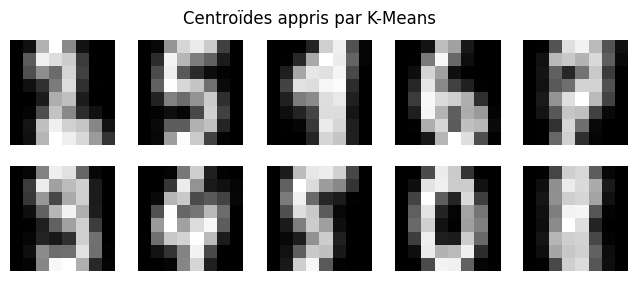

In [101]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers):
    ax.imshow(center, cmap='gray')
    ax.axis('off')
plt.suptitle('Centroïdes appris par K-Means')
plt.show()

## Métriques et clustering

Dans les questions précédentes, nous avons vu deux métriques :
- appliquer ces deux métriques pour les données ``digits``
- quel sens donner à ces résultats ?

In [103]:
ari = adjusted_rand_score(y,clusters)
print(f"ARI (Adjusted Rand Index) : {ari:.3f}")


ARI (Adjusted Rand Index) : 0.615


In [104]:
silhouette_score(X,clusters)

0.18555026309037873

## Pour aller plus loin

On pourra se poser la question de : 
- remplacer le k-means par un mélange de gaussiennes dans le TP (voire même de les comparer)
- voir comment utiliser k-means comme un prétraitement
- tester l'hypothèse de isotropie des clusters en changeant la forme des données synthétiques du premier exercice.